# <center>Capstone Project - The Battle of the Neighborhoods (Week 2)</center>
# <center>Foursquare Users Segmentation</center>
### <center>Applied Data Science Capstone by IBM/Coursera<center>

---
## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)
---

## Introduction: Business Problem <a name="introduction"></a>

Let's assume we are going to establish new retail business venue in a city, but we still don't know what it should be. To make our choice we fist need to answer several questions, that can make our intend more specific:  
  
* What type of venue would be popular in this particular city ?  
* Who would be our clients ? What they prefer ? What are their share of the total customers ?  

Definitely its not all questions one needs to set up our own business. Still it is a good start for creating business plan based on data, instead of assumptions.

## Data <a name="data"></a>

One of the possible approaches of solving the problem we described is to carry out customer segmentation analysis. To do that we are going to use Foursquare API (venues location and user's profile) in following steps:  

1. Find one of the most popular venues in the city and its users.  
2. Find friend of these users, who live in the same city. Find friends of their friends and so on until we get all Foursquare users of the city.  
3. Get "tastes" for each user, based on his Foursquare profile.   

For steps 1-2 we will use standard Foursquare API (explore and friends Endpoints). Step №2 continues until the number of obtained user ids after iteration does not change.  
  
For getting data needed at step №3 using standard Foursquare API is not enough. Foursquare describes tastes Endpoint in its the documentation, however its available only for part of authorized users (the user himself and maybe his friends). Any other person will get en authorization error in response. We could use list Endpoint to get "venueslikes" ( a list of venues, which was likes be the user) but via "personal" account it allows you to get only 2 venues per users list, which is not enough to build the relevant tastes profile for clustering. On the other hand all lists including venueslikes are available at web page of each users profile, so why don't we try to get them directly from web pages?  
  
I'd like to demonstrate the hole process on my native city Rostov-on-Don, Russia because It has just few thousands of active Foursquare's users, so obtaining the data would be much faster comparing to big megapolis. In spite of that, all of the code is suitable for any other place in the world.

In [3]:
#Here is all we need for this project
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import re #For regular expressions when parsing web pages
import time #For delay between parsing web pages
from sklearn.cluster import KMeans

%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.cm as cm
import matplotlib.colors as colors

import folium

In [4]:
#Get coordinates of the city, where we want to analyze Forsquare users.

address = 'Rostov-on-Don, Russia'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address,latitude, longitude))

The geograpical coordinate of Rostov-on-Don, Russia are 47.2213858, 39.7114196.


In [5]:
#Set up credencials for Forsquare Developer's Account

CLIENT_ID = '1LBY0SOLMQWYE0H040VQ2IXISHXAHBRFFFEBHJGUZQCCOY0U' # your Foursquare ID
CLIENT_SECRET = 'KWIT54XNJHB5ANS3UPOLM0H1ILQ1P5LVLNV35BX5VXLNF22O' # your Foursquare Secret
VERSION = '20190105' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1LBY0SOLMQWYE0H040VQ2IXISHXAHBRFFFEBHJGUZQCCOY0U
CLIENT_SECRET:KWIT54XNJHB5ANS3UPOLM0H1ILQ1P5LVLNV35BX5VXLNF22O


In [6]:
#Get 100 most popular venues in the city center.

radius = 1000
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
url


'https://api.foursquare.com/v2/venues/explore?client_id=1LBY0SOLMQWYE0H040VQ2IXISHXAHBRFFFEBHJGUZQCCOY0U&client_secret=KWIT54XNJHB5ANS3UPOLM0H1ILQ1P5LVLNV35BX5VXLNF22O&ll=47.2213858,39.7114196&v=20190105&radius=1000&limit=100'

In [7]:
#Get response in JSON format

results = requests.get(url).json()
#results

In [8]:
#Transform JSON into Pandas DataFrame

venues = results['response']['groups'][0]['items']
venues_df = json_normalize(venues)
print(venues_df.shape)
venues_df.head()

(100, 22)


,reasons.count,reasons.items,referralId,venue.categories,venue.id,venue.location.address,venue.location.cc,venue.location.city,venue.location.country,venue.location.crossStreet,...,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.neighborhood,venue.location.postalCode,venue.location.state,venue.name,venue.photos.count,venue.photos.groups,venue.venuePage.id
0,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-547eeeb7498ea45963756015-0,"[{'id': '4bf58dd8d48988d119941735', 'name': 'H...",547eeeb7498ea45963756015,"Темерницкая ул., 81",RU,Ростов-на-Дону,Россия,Газетный,...,"[{'label': 'display', 'lat': 47.21948036938454...",47.219480,39.709308,ленинский,344002,Ростовская обл.,OBLAKA LiL Lounge / ОБЛАКА,0,[],NaN
1,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-56f6b2ab498e6155438c01cd-1,"[{'id': '4bf58dd8d48988d119941735', 'name': 'H...",56f6b2ab498e6155438c01cd,"Темерницкая ул., 63",RU,Ростов-на-Дону,Россия,Соборный,...,"[{'label': 'display', 'lat': 47.218983, 'lng':...",47.218983,39.712845,NaN,344002,Ростовская обл.,Oblaka bar & grill,0,[],NaN
2,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4df8cf21c65b6739205d8aaf-2,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",4df8cf21c65b6739205d8aaf,"пер. Семашко, 51",RU,Ростов-на-Дону,Россия,пер. Думский Проезд,...,"[{'label': 'display', 'lat': 47.22257423557899...",47.222574,39.712409,NaN,344002,Ростовская обл.,Park Культуры,0,[],NaN
3,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-5645fec7498e4762f6d7aa80-3,"[{'id': '4bf58dd8d48988d11e951735', 'name': 'C...",5645fec7498e4762f6d7aa80,Семашко 51,RU,Ростов-наДону,Россия,NaN,...,"[{'label': 'display', 'lat': 47.22267662143176...",47.222677,39.712153,NaN,NaN,NaN,Сыроварня,0,[],NaN
4,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-55c5f70c498ee4b5cf71c98a-4,"[{'id': '5370f356bcbc57f1066c94c2', 'name': 'B...",55c5f70c498ee4b5cf71c98a,"Газетный пер., 50",RU,Ростов-на-Дону,Россия,NaN,...,"[{'label': 'display', 'lat': 47.22216115458863...",47.222161,39.715473,NaN,344000,Ростовская обл.,"Магазин крафтового пива ""Бутылочка""",0,[],NaN


In [9]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [10]:
#Clean up the list of venues

venues_df=venues_df[['venue.name','venue.categories','venue.id',
                    'venue.location.address','venue.location.lat','venue.location.lng',
                    'venue.location.postalCode']]
venues_df['venue.categories']=venues_df.apply(get_category_type, axis=1)

In [11]:
venues_df.head()

,venue.name,venue.categories,venue.id,venue.location.address,venue.location.lat,venue.location.lng,venue.location.postalCode
0,OBLAKA LiL Lounge / ОБЛАКА,Hookah Bar,547eeeb7498ea45963756015,"Темерницкая ул., 81",47.219480,39.709308,344002
1,Oblaka bar & grill,Hookah Bar,56f6b2ab498e6155438c01cd,"Темерницкая ул., 63",47.218983,39.712845,344002
2,Park Культуры,Restaurant,4df8cf21c65b6739205d8aaf,"пер. Семашко, 51",47.222574,39.712409,344002
3,Сыроварня,Cheese Shop,5645fec7498e4762f6d7aa80,Семашко 51,47.222677,39.712153,NaN
4,"Магазин крафтового пива ""Бутылочка""",Beer Store,55c5f70c498ee4b5cf71c98a,"Газетный пер., 50",47.222161,39.715473,344000


In [12]:
#We need id of some local users, so let's get likes of the venue  with id = 4df8cf21c65b6739205d8aaf
url2 = 'https://api.foursquare.com/v2/venues/4df8cf21c65b6739205d8aaf/likes?client_id={}&client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION)

In [13]:
#As you can see, we got only 3 likes, while there are actually 404 of them. Looks like there are some limits concerning not only tips and photos per 1 venue but also likes per 1 venue.
results2 = requests.get(url2).json()
results2

{'meta': {'code': 200, 'requestId': '5ce69b22351e3d1287744867'},
 'response': {'likes': {'count': 295,
   'summary': '295 Likes',
   'items': [{'id': '64412634',
     'firstName': 'Алексей',
     'lastName': 'Золотницкий',
     'gender': 'male',
     'photo': {'prefix': 'https://fastly.4sqi.net/img/user/',
      'suffix': '/64412634_C9xVFyfa_BCaobzojinV3N9xPzxjNvP3FOwjM_X4kZWH8WHpWoUIt4_0MEph-Xj3KJqzzm6f1.jpg'}},
    {'id': '496560633',
     'firstName': 'Кристина',
     'gender': 'female',
     'photo': {'prefix': 'https://fastly.4sqi.net/img/user/',
      'suffix': '/blank_girl.png',
      'default': True}},
    {'id': '57372260',
     'firstName': 'Yono',
     'lastName': 'Oko',
     'gender': 'female',
     'photo': {'prefix': 'https://fastly.4sqi.net/img/user/',
      'suffix': '/YAGM5FK5WYAD1WBQ.jpg'}}]}}}

In [14]:
#Try if we can get liked venues using USER/VENUELIKES Endpoint
#No, we have no privilages to get users likes.
url3 = 'https://api.foursquare.com/v2/users/496560633/venuelikes?client_id={}&client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION)
results3 = requests.get(url3).json()
results3

{'meta': {'code': 403,
  'errorType': 'not_authorized',
  'errorDetail': 'A user is required to call this endpoint.',
  'requestId': '5ce69b23dd57970e251626aa'},
 'response': {}}

### Getting all Foursqaure users within city

The first think we need to do is to get all users within the city for segmentation.  
We can esaly do it by getting friends (and friends of friend...) filtering them by their homecity.

In [15]:
#Take id from one of the previous users and get all his friends in Rostov-on-Don city.
url4 = 'https://api.foursquare.com/v2/users/51914914/friends?client_id={}&client_secret={}&v={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, 200)
results4 = requests.get(url4).json()
friends_df=json_normalize(results4['response']['friends']['items'])
friends_df=friends_df[friends_df['homeCity'].str.contains('Rostov')]
friends_df

,bio,firstName,gender,homeCity,id,lastName,lists.groups,photo.default,photo.prefix,photo.suffix,tips.count
0,,Marina,female,Rostov,25184784,Stepanyants,"[{'type': 'created', 'count': 2, 'items': []}]",NaN,https://fastly.4sqi.net/img/user/,/XRO2IGEKEJCFH1D2.jpg,35
5,,Natalie,female,Rostov,44559623,NaN,"[{'type': 'created', 'count': 2, 'items': []}]",NaN,https://fastly.4sqi.net/img/user/,/OWLHJLQTHEN10ZCN.jpg,2
7,,Сона,none,"Rostov-na-Donu, 61",64051846,Арамян,"[{'type': 'created', 'count': 2, 'items': []}]",True,https://fastly.4sqi.net/img/user/,/blank_boy.png,0
8,,Славик,male,"Rostov-na-Donu, 61",65702799,Ароян,"[{'type': 'created', 'count': 2, 'items': []}]",True,https://fastly.4sqi.net/img/user/,/blank_boy.png,0
9,,Rimmulka S.,female,Rostov,31644524,NaN,"[{'type': 'created', 'count': 2, 'items': []}]",NaN,https://fastly.4sqi.net/img/user/,/HDDU3ASLNO213TYB.jpg,0
10,,Latika,female,Rostov,33783283,NaN,"[{'type': 'created', 'count': 2, 'items': []}]",NaN,https://fastly.4sqi.net/img/user/,/5JIQE3MAOFJCPEDV.jpg,4
11,,Гурам,male,Rostov,41346236,12,"[{'type': 'created', 'count': 2, 'items': []}]",NaN,https://fastly.4sqi.net/img/user/,/YTWOLUIQRDWF0RQ4.jpg,1


In [16]:
#Continue the process for friends of friends.
#We need to run this code until the shape of DataFrame will not change.
#For Rostov-on_Don 3 times were enough

#Here is the first run (the third one is very long)
i=1
for ids in friends_df['id']:
    print('Processing -> id={}, index={} of {}'.format(ids,i,friends_df.shape[0]))
    url='https://api.foursquare.com/v2/users/{}/friends?client_id={}&client_secret={}&v={}&limit={}'.format(ids, CLIENT_ID, CLIENT_SECRET, VERSION, 200)
    results = requests.get(url).json()
    temp_df=json_normalize(results['response']['friends']['items'])
    temp_df=temp_df[temp_df['homeCity'].str.contains('Rostov')]
    friends_df=friends_df.append(temp_df,ignore_index=True,sort=False)
    i+=1
    friends_df.drop_duplicates(subset=['id'],inplace=True)

Processing -> id=25184784, index=1 of 7
Processing -> id=44559623, index=2 of 48
Processing -> id=64051846, index=3 of 54
Processing -> id=65702799, index=4 of 54
Processing -> id=31644524, index=5 of 54
Processing -> id=33783283, index=6 of 61
Processing -> id=41346236, index=7 of 76


In [17]:
#Finally we've got all users.
#I saved them to CSV to save time in future.

friends_df=pd.read_csv('rostov_users.csv',index_col=0)
friends_df.reset_index(drop=True, inplace=True)
friends_df.tail()

,bio,firstName,gender,homeCity,id,lastName,lists.groups,photo.default,photo.prefix,photo.suffix,tips.count,superuser
6723,NaN,Юлия,female,Rostovskaya Oblast’,71375543,Шаблий,"[{'type': 'created', 'count': 2, 'items': []}]",NaN,https://fastly.4sqi.net/img/user/,/71375543-NTXWFMK0EJRGJ5J3.jpg,0,NaN
6724,NaN,Андрей,male,Rostovskaya Oblast’,66134030,Бородаев,"[{'type': 'created', 'count': 2, 'items': []}]",NaN,https://fastly.4sqi.net/img/user/,/4X3R2XAR5XM4VKX1.jpg,0,NaN
6725,NaN,Sergey,male,"Rostov-on-don, 61",54619814,Mizgirev,"[{'type': 'created', 'count': 2, 'items': []}]",True,https://fastly.4sqi.net/img/user/,/blank_boy.png,0,NaN
6726,NaN,Дарья,female,"Rostov, Rostovskaya Oblast', Russia",81085835,Воскобоева,"[{'type': 'created', 'count': 2, 'items': []}]",NaN,https://fastly.4sqi.net/img/user/,/81085835-FMLZLPYOO0RV3JZA.jpg,0,NaN
6727,NaN,Екатерина,female,Rostov,45203511,NaN,"[{'type': 'created', 'count': 2, 'items': []}]",NaN,https://fastly.4sqi.net/img/user/,/RKT3C33YBEGB5P13.jpg,0,NaN


### Getting User's Tastes

Now its time to get users tastes. Unfortunately we can't use users/venuelikes endpoint as it was shown before.  
But if you visit any users web page, you'll see, that all liked venues are available in lists/venuelikes. (One of two standard lists for any user)  
So we can run through all these pages and parse the data.
See the following comments in code.

In [18]:
#Set up HTTPS Proxy.
#It will be used in requests while getting users web profiles.
#Probably Foursquare don't like when someone is trying to automate working with their web and block by IP address for a few hours.
#If it happens, You can simply change proxy to another and continue to download the data.

http_proxy  = ""
https_proxy = "51.254.195.132:3128"
ftp_proxy   = ""

proxyDict = { 
              "http"  : http_proxy, 
              "https" : https_proxy, 
              "ftp"   : ftp_proxy
            }

In [19]:
#In web page code you can find the info about every vaenue in list in such patterns:
"""
"venue":{"name":"New York Coffee","beenHere":{},"stats":{"checkinsCount":635,"usersCount":266,"tipCount":11},"location":{"city":"Уфа","crossStreet":"Верхнеторговая пл., 1",
"lng":55.944099426269524,"contextLine":"Уфа","state":"Башкортостан","country":"Россия","postalCode":"450008","address":"Гостиный двор","cc":"RU","lat":54.72469454657516},
"urlSig":"CQD3KKqxEwwqY7lJ5kNrlSJ1tn8=","venuePage":{"id":"110072618"},"contact":{"formattedPhone":"8 (937) 840-02-00","instagram":"nyc.time","phone":"89378400200"},
"ratingColor":"C5DE35","id":"54747575498e09ca697a8a3d","canonicalPath":"\/v\/new-york-coffee\/54747575498e09ca697a8a3d","canonicalUrl":"https:\/\/foursquare.com\/v\/new-york-coffee\/54747575498e09ca697a8a3d",
"rating":7.6,"categories":[{"pluralName":"Кофейни","name":"Кофейня","icon":{"prefix":"https:\/\/ss3.4sqi.net\/img\/categories_v2\/food\/coffeeshop_",
"mapPrefix":"https:\/\/ss3.4sqi.net\/img\/categories_map\/food\/coffeeshop","suffix":".png"},"id":"4bf58dd8d48988d1e0931735","shortName":"Кофейня","primary":true}],
"ratingSignals":43,"verified":true,"like":false}},{"photo":{"prefix":"https:\/\/fastly.4sqi.net\/img\/general\/","suffix":"\/24388723_Wn5b64FqkrfoszpkWjWWIi6GMwQC21OrKn_VgBzn0cY.jpg",
"height":575,"id":"51693921e4b0a2ef1ed5ca59","createdAt":1365850401,"width":960,"visibility":"public","user":{"photo":{"prefix":"https:\/\/fastly.4sqi.net\/img\/user\/","suffix":"\/NP2O40RMT4GFPLFS.jpg"},
"lastName":"Rynkovoy","firstName":"Yriy","id":"24388723","canonicalPath":"\/user\/24388723","canonicalUrl":"https:\/\/foursquare.com\/user\/24388723","isAnonymous":false,"gender":"male"}},
"id":"v4e79bb111f6e07f917cc4d4d","createdAt":1483088672,"user":{"lists":{"groups":[{"type":"created","count":2,"items":[]}]},"photo":{"prefix":"https:\/\/fastly.4sqi.net\/img\/user\/",
"suffix":"\/333898340_cj3xH9VU_ALXp4OnYcTmv8mMFH5_t8SES77S1qL5QVXjEncNZdT3w57YdFlZV8RFuyqsyerBR.jpg"},"contact":{},"bio":"","lastName":"Булатова","firstName":"Дария","id":"333898340",
"canonicalPath":"\/user\/333898340","canonicalUrl":"https:\/\/foursquare.com\/user\/333898340","tips":{"count":14},"isAnonymous":false,"homeCity":"Krasnodar, 25","gender":"female"}
"""
#Here is a lot of usful data we can get for free (without spending premium calls), but for this project we need only category and id of each venue in the list.
#The following function finds all such patterns and parse them.

def _GetVenuesFromPage(df, page, user_id):
    liked_venues=re.findall('\"venue\":\{.+?gender?.+?\}',page.text)
    liked_df=pd.DataFrame(columns={'user.id','venue.id','venue.categories'})
    if len(liked_venues)==0:
        #User has no liked venues, or our IP was blocked by Foursquare
        print("!!! List is empty !!!")
        liked_df.loc[0,'user.id']=user_id
        liked_df.loc[0,'venue.id']=0
        liked_df.loc[0,'venue.categories']="NA" 
    i=0
    for v in liked_venues:
        ids=re.findall('\"id\":\"[0123456789abcdef]{15,}\"',v)
        #The are 4 different id's in the pattern. The id of the venue is the first
        ids=re.findall('[0123456789abcdef]{15,}',ids[0])
        category=re.findall('\"categories\":.+?name\":\".+?\"',v)
        if len(category)>0:
            category=category[0].split(':')[-1][1:-1]
            liked_df.loc[i,'user.id']=user_id
            liked_df.loc[i,'venue.id']=ids[0]
            liked_df.loc[i,'venue.categories']=category                          
            i=i+1
    df=df.append(liked_df,ignore_index=True)
    #print("df shape=%s, liked_df shape=%s",df.shape,liked_df.shape)
    return df

In [20]:
#If a user has more then 30 liked venues, there will be more then one page in his liked venues list
#So we have to repeat the process for all pages (page 2, 3.... and so on)

def GetVenuesLiked(df, url, user_id):
    GoOn=True
    page_num=2
    next_page=""
    while (GoOn):
        print("parsing page -> "+url+next_page)
        page = requests.get(url+next_page,proxies=proxyDict)
        df=_GetVenuesFromPage(df,page,user_id)
        if page.text.find('?page='+str(page_num))!=-1:
            next_page='?page='+str(page_num)
            page_num+=1
            #If delay between two requests will be less then 1.1-2 sec, you will be blocked soon. 2-3 sec - is ok! 
            time.sleep(3)
        else:
            GoOn=False
            #If delay between two requests will be less then 1.1-2 sec, you will be blocked soon. 2-3 sec - is ok! 
            time.sleep(3)
    #print(page.text)
    return df

In [ ]:
#This code run GetVenuesLiked function in loop for all users.
#This could take pretty long time. At that time you can be blocked, proxy can be turned off, an so on.
#Because of that we save current results to csv after each user. 
#So if something goes wrong we can resume downloading from the same user.

#liked_df=pd.DataFrame(columns={'user.id','venue.id','venue.categories'})
liked_df=pd.read_csv('user_likes.csv',index_col=0)
print(liked_df.shape)
liked_df.drop_duplicates(subset=['user.id','venue.id'],inplace=True)
print(liked_df.shape)
for ids in friends_df['id']:
    if (ids in list(liked_df['user.id']))==False:
        i=0
        link=""
        #Sometimes Foursquare can not handle the reqest from the first try
        while (link=="") and (i<10):
            try:
                i+=1
                #Get link to users venuelikes page
                url='https://api.foursquare.com/v2/users/{}?client_id={}&client_secret={}&v={}&limit={}'.format(ids, CLIENT_ID, CLIENT_SECRET, VERSION, 200)
                results = requests.get(url).json()
                link=results['response']['user']['lists']['groups'][2]['items'][1]['canonicalUrl']
            except Exception:
                print('Unable to resolve the link for id=',ids)
        
        try:
            liked_df=GetVenuesLiked(liked_df, link, ids)
            liked_df.to_csv('user_likes.csv')
        except Exception:
            print('Unable to get likes for id=',ids,Exception)
print('All is done!')

In [21]:
#Load final database with all users likes
liked_df=pd.read_csv('user_likes.csv',index_col=0)
liked_df.reset_index(drop=True, inplace=True)
print("The shape is ",liked_df.shape)
liked_df.head(15)

The shape is  (53914, 3)


,user.id,venue.id,venue.categories
0,25184784,5b3f5dbf5c6838002c50ace1,Fish Market
1,25184784,58e361999f8b860f40ebdf49,Food & Drink Shop
2,25184784,4dc6f5e7d164eb9ca0152450,Church
3,25184784,4e51769562e14b77e3b8aa2a,Park
4,25184784,4f8a9b94e4b0b1c4b0d053fc,Home (private)
5,25184784,58724e1dac329156c7ca8566,Fast Food Restaurant
6,25184784,538c6c26498ef911b52f1b79,Housing Development
7,25184784,4ee351779adf3982fe5e5511,Liquor Store
8,25184784,52e681c0498e85424fb19252,Restaurant
9,25184784,4fe72edce4b09fd374080fc5,Parking


### How many unique categories are presented ?

In [22]:
print(liked_df['venue.categories'].unique()[0:30])
print("Users of Rostov-on-Don, Russia have liked {} unique venues all over the world having {} \
unique categories.".format(len(liked_df['venue.id'].unique()),len(liked_df['venue.categories'].unique())))

['Fish Market' 'Food & Drink Shop' 'Church' 'Park' 'Home (private)'
 'Fast Food Restaurant' 'Housing Development' 'Liquor Store' 'Restaurant'
 'Parking' 'Burger Joint' 'Theme Park Ride \\/ Attraction' 'Bank'
 'Toy \\/ Game Store' 'Butcher' 'Miscellaneous Shop' 'Boutique'
 'Coffee Shop' 'Dessert Shop' 'Candy Store' 'Snack Place' 'Post Office'
 'Kids Store' 'Road' 'Scenic Lookout' 'Village' 'City' 'Baby Store'
 'Clothing Store' 'Cave']
Users of Rostov-on-Don, Russia have liked 20040 unique venues all over the world having 585 unique categories.


### What are the fost popular ?

In [23]:
liked_df['venue.categories'].value_counts()

Restaurant                 2535
Shopping Mall              2282
Home (private)             2234
Coffee Shop                2185
Café                       1450
Italian Restaurant         1123
Fast Food Restaurant        987
Hotel                       958
Multiplex                   957
Asian Restaurant            940
Park                        940
Salon \/ Barbershop         903
Plaza                       823
Gastropub                   747
Nightclub                   669
Bar                         651
Grocery Store               552
Japanese Restaurant         536
Pub                         526
Big Box Store               493
Cocktail Bar                488
Bank                        484
Bakery                      476
Gym \/ Fitness Center       468
Office                      458
Road                        457
Sushi Restaurant            446
City                        380
Beach                       376
Gym                         353
                           ... 
Israeli 


### Make some cleaning and preparation for clustering


## Methodology <a name="methodology"></a>

Now, when the data is obtained we can achieve user's segmentation by following steps:

1. Transform the list of liked venues for each user into their taste profile.
2. Use clustering method to divide users into separate segments based on their taste profile.
3. Analyze the segments to discover differences between them.

In [24]:
liked_df.dtypes

user.id              int64
venue.id            object
venue.categories    object
dtype: object

In [25]:
#All data needs to be cast to same data types (user's id - int, venues id - str)
liked_df['user.id']=liked_df['user.id'].astype('int64', copy=False)
liked_df['venue.id']=liked_df['venue.id'].astype(str)
liked_df['venue.categories']=liked_df['venue.categories'].astype(str)

liked_df=liked_df.loc[liked_df['venue.id']!='0']
liked_df.dropna(inplace=True)

In [26]:
#Use the same technique as in neighborhood clustering
Likes_dummies=pd.get_dummies(liked_df['venue.categories'], prefix="", prefix_sep="")
Likes_dummies['user.id']=liked_df['user.id']
fix_columns=[Likes_dummies.columns[-1]]+list(Likes_dummies.columns[:-1])
Likes_dummies=Likes_dummies[fix_columns]
User_likes_stat=Likes_dummies.groupby('user.id').mean().reset_index()
User_likes_stat.head()

,user.id,Accessories Store,Adult Boutique,Adult Education Center,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Gate,Airport Lounge,...,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,Çöp Şiş Place
0,1699620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1949677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2534871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2972779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.015385,0.015385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3264617,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Analysis <a name="analysis"></a>

Let's build several tables and plots that help us to understand the difference between clusters and and some more details about them.

### Clustering with KMeans

Now we have User_likes_stat DataFrame, contains each users profile, based on the venues they liked.  
My choice is using the simplest method of clustering - KMeans, because:  
1. It's fast  
2. There is no arbitrary shaped clusters for using DBSCAN  
3. At this moment we don't need hierarchical structure, as we don't know how to interpret it  
  
The only problem we have is choosing the number of clusters.  
My decision is to get maximum users diversity, keeping the number users within the smallest cluster commensurate with other clusters.  
If we use k=4 we get 81 user in smallest cluster, next we have clusters with 153 and 374 users which is about twice bigger.  

In [27]:
# set number of clusters
kclusters = 4

users_grouped_clustering = User_likes_stat.drop('user.id', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, n_init = 12,init = "k-means++").fit(users_grouped_clustering)

#count the number of users within each cluster
import collections
collections.Counter(kmeans.labels_)

Counter({0: 3252, 3: 81, 2: 153, 1: 368})

In [28]:
users_grouped_clustering['Cluster']=kmeans.labels_
User_cluster_stat=users_grouped_clustering.groupby('Cluster').mean().reset_index()

In [29]:
def return_most_common_category(row, num_top_categories):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_categories]

In [30]:
num_top_categoties = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Cluster']
for ind in np.arange(num_top_categoties):
    try:
        columns.append('{}{} Most Common Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Category'.format(ind+1))

# create a new dataframe
cluster_common_cat = pd.DataFrame(columns=columns)
cluster_common_cat['Cluster'] = User_cluster_stat['Cluster']

for ind in np.arange(User_cluster_stat.shape[0]):
    cluster_common_cat.iloc[ind, 1:] = return_most_common_category(User_cluster_stat.iloc[ind, :], num_top_categoties)
    
collections.Counter(kmeans.labels_)[0]

counter=collections.Counter(kmeans.labels_)
for ind in np.arange(User_cluster_stat.shape[0]):
    cluster_common_cat.loc[ind,'Users In Cluster']=counter[ind]

In [31]:
cluster_common_cat

,Cluster,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category,Users In Cluster
0,0,Shopping Mall,Home (private),Restaurant,Café,Coffee Shop,Salon \/ Barbershop,Italian Restaurant,Asian Restaurant,Hotel,Multiplex,3252.0
1,1,Home (private),Asian Restaurant,Shopping Mall,Café,Salon \/ Barbershop,Nightclub,Office,Plaza,Sushi Restaurant,Italian Restaurant,368.0
2,2,Restaurant,Home (private),New American Restaurant,Gym \/ Fitness Center,Hotel,Fast Food Restaurant,Office,Gastropub,Coffee Shop,Asian Restaurant,153.0
3,3,Coffee Shop,Home (private),Office,Shopping Mall,Italian Restaurant,Café,Gym \/ Fitness Center,Sushi Restaurant,Pelmeni House,Hotel,81.0


In [32]:
#Add lables to user's DataFrame
users_grouped_clustering['user.id']=User_likes_stat['user.id']
users_df=pd.merge(friends_df,users_grouped_clustering[['user.id','Cluster']],left_on='id',right_on='user.id', how='left').drop('user.id',axis=1)
users_df.head()

,bio,firstName,gender,homeCity,id,lastName,lists.groups,photo.default,photo.prefix,photo.suffix,tips.count,superuser,Cluster
0,NaN,Marina,female,Rostov,25184784,Stepanyants,"[{'type': 'created', 'count': 2, 'items': []}]",NaN,https://fastly.4sqi.net/img/user/,/XRO2IGEKEJCFH1D2.jpg,30,NaN,0.0
1,NaN,Natalie,female,Rostov,44559623,NaN,"[{'type': 'created', 'count': 2, 'items': []}]",NaN,https://fastly.4sqi.net/img/user/,/OWLHJLQTHEN10ZCN.jpg,2,NaN,0.0
2,NaN,Сона,none,"Rostov-na-Donu, 61",64051846,Арамян,"[{'type': 'created', 'count': 2, 'items': []}]",True,https://fastly.4sqi.net/img/user/,/blank_boy.png,0,NaN,NaN
3,NaN,Славик,male,"Rostov-na-Donu, 61",65702799,Ароян,"[{'type': 'created', 'count': 2, 'items': []}]",True,https://fastly.4sqi.net/img/user/,/blank_boy.png,0,NaN,NaN
4,NaN,Rimmulka S.,female,Rostov,31644524,NaN,"[{'type': 'created', 'count': 2, 'items': []}]",NaN,https://fastly.4sqi.net/img/user/,/HDDU3ASLNO213TYB.jpg,0,NaN,NaN


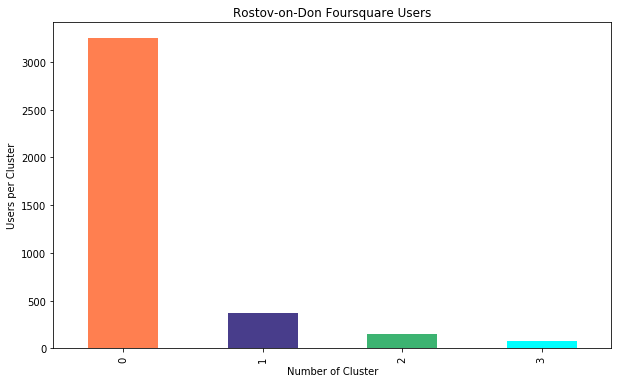

In [33]:
cluster_common_cat['Users In Cluster'].plot(kind='bar',figsize=(10,6),color=['coral', 'darkslateblue', 'mediumseagreen','cyan'])
plt.title('Rostov-on-Don Foursquare Users')
plt.xlabel('Number of Cluster')
plt.ylabel('Users per Cluster')
plt.show()

So we have 4 segments the first one is bigger then 3 others in total. The other 3 reduced by half with each next cluster.

In [34]:
#Users with NaN in Cluster have empty venuelikes list. Lets delete them.
#Also lets delete columns we don't need any more
users_df=users_df[['id','firstName','lastName','gender','homeCity','Cluster']]
users_df=users_df.dropna(axis=0)
users_df.head(15)

,id,firstName,lastName,gender,homeCity,Cluster
0,25184784,Marina,Stepanyants,female,Rostov,0.0
8,27579356,Ева,:),female,Rostov,0.0
11,22892110,Хазар,Оланян,male,Rostov,0.0
15,45822397,Irina,Davidyan,female,Rostov,0.0
16,28490008,Sonya,Kolomiytseva,female,"Rostov, Rostovskaya Oblast', Russia",0.0
18,36429174,Elena,S,female,Rostov-na-donu,0.0
20,37748975,Армен,Ногаян,male,Rostov,0.0
22,49269252,Karina,Chubarova,female,Rostov,0.0
24,25552508,Мария,Котанчян,female,Rostov,0.0
26,21506864,Anna,Chuzhikova,female,Rostov,0.0


Take a look at geder distribution

In [35]:

u_df=pd.get_dummies(data=users_df,columns=['gender'])
gender_stat=u_df[['Cluster','gender_female','gender_male','gender_none']].groupby('Cluster').mean()
gender_stat.style.format({'gender_female':'{:.2%}','gender_male':'{:.2%}','gender_none':'{:.2%}'})


,gender_female,gender_male,gender_none
Cluster,,,
0.0,56.24%,42.46%,1.30%
1.0,51.48%,45.57%,2.95%
2.0,56.41%,40.17%,3.42%
3.0,61.67%,38.33%,0.00%


Text(0.5, 1.0, "Rostov-on-Don - Foursquare User's by Gender")

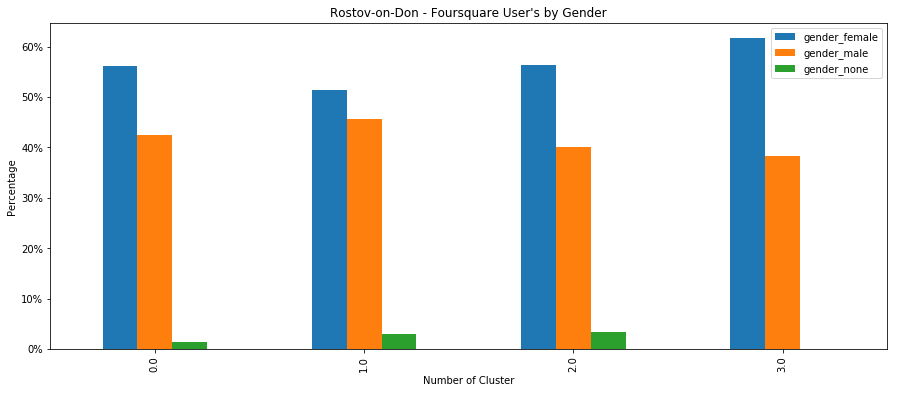

In [36]:
ax=(gender_stat*100).plot(kind='bar',figsize=(15,6))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xlabel('Number of Cluster')
ax.set_ylabel('Percentage')
ax.set_title('Rostov-on-Don - Foursquare User\'s by Gender')

Now let's explore how active users in different clusters ? (How many venues they liked)

In all clusters women have bigger share then men. That meen the share is not equal for the whole dataset. (Perhaps - it is the feature of local users) But in cluster №3 the destinguish is maximum (61% - women and only 38% - men)

In [37]:
#Find length of venuelikes list for each user
a_df=liked_df.groupby('user.id').count().reset_index()
a_df.drop('venue.categories',axis=1,inplace=True)
a_df.columns=['id','venuelikes']
users_df=pd.merge(users_df,a_df,on='id',how='inner')
users_df.head()

,id,firstName,lastName,gender,homeCity,Cluster,venuelikes
0,25184784,Marina,Stepanyants,female,Rostov,0.0,309
1,27579356,Ева,:),female,Rostov,0.0,1
2,22892110,Хазар,Оланян,male,Rostov,0.0,8
3,45822397,Irina,Davidyan,female,Rostov,0.0,11
4,28490008,Sonya,Kolomiytseva,female,"Rostov, Rostovskaya Oblast', Russia",0.0,2


In [38]:
#Transform dataframe for box plot
active_df=pd.DataFrame()
for i in range(0,kclusters):
    active_df['Cluster {}'.format(i)]=pd.Series(list(users_df[users_df['Cluster']==i]['venuelikes']))

Text(0.5, 1.0, "Rostov-on-Don - Foursquare User's Activity")

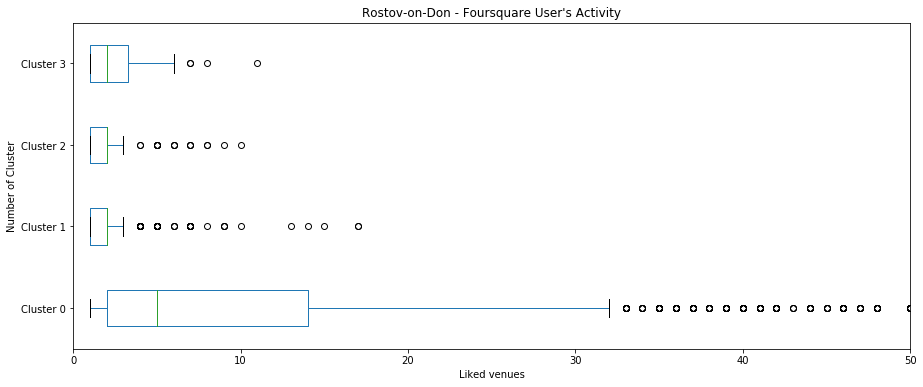

In [39]:
ax=active_df.plot(kind='box',figsize=(15,6),vert=False,whis=1.5)
ax.set_xlim(left=0,right=50)
ax.set_xlabel('Liked venues')
ax.set_ylabel('Number of Cluster')
ax.set_title('Rostov-on-Don - Foursquare User\'s Activity')

Explore Top-10 venues for each cluster

Comparing the activity of user in different clusters: Cluster №0 not only the biggest, but also most active (median is 5 likes per user, maximum is 500).

In [40]:
top_venues=pd.DataFrame()
l_v_clustered=pd.merge(liked_df,users_df[['id','Cluster']],left_on='user.id',right_on='id',how='left')
for i in range(0,kclusters):
    top_venues=top_venues.append(pd.DataFrame([l_v_clustered[l_v_clustered['Cluster']==i].groupby('venue.id').count().sort_values(by='id',ascending=False).index[0:10],[i]*10]).transpose())
top_venues.reset_index(drop=True,inplace=True)
top_venues.columns=['venue.id','Cluster']
top_venues.head(11) 

,venue.id,Cluster
0,4c3afe4e1a1cd13a4691b50d,0
1,4ef5f1a5f790731250ba0833,0
2,4c3c51bc7d00d13af0ae3850,0
3,4c1a5e978b3aa593187f955f,0
4,5006b1e1e4b0a69557c73b79,0
5,4c45c614f0bdd13ac264cbcc,0
6,4c7a46e4bd346dcb9d04f8ef,0
7,509b9cbc498e0d95ea0e2ff3,0
8,4c430e2bff711b8d475a1405,0
9,4cbbd6a5c7228cfa115820ce,0


In [41]:
#Using venue/details(premium calls) endpoint to get info about venues
venues_detail=pd.DataFrame()
for ids in top_venues['venue.id']:
    url= 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(ids, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    venues_detail=venues_detail.append(json_normalize(result['response']['venue']),sort=False)

In [42]:
venues_detail.reset_index(drop=True,inplace=True)
venues_detail.to_csv('top_venues.csv')
venues_detail.head()

,attributes.groups,beenHere.count,beenHere.lastCheckinExpiredAt,beenHere.marked,beenHere.unconfirmedCount,bestPhoto.createdAt,bestPhoto.height,bestPhoto.id,bestPhoto.prefix,bestPhoto.source.name,...,page.pageInfo.links.items,page.user.contact.twitter,contact.instagram,menu.anchor,menu.externalUrl,menu.label,menu.mobileUrl,menu.type,menu.url,location.neighborhood
0,"[{'type': 'payments', 'name': 'Credit Cards', ...",0,0,False,0,1.364230e+09,959.0,51507ddae4b08b309fbb911a,https://fastly.4sqi.net/img/general/,Foursquare for iOS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[{'type': 'payments', 'name': 'Credit Cards', ...",0,0,False,0,1.485938e+09,4912.0,58919d04d5b44f3e2ebc8e87,https://fastly.4sqi.net/img/general/,Foursquare Web,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[{'type': 'payments', 'name': 'Credit Cards', ...",0,0,False,0,1.363021e+09,959.0,513e0d38e4b0b886b50398a0,https://fastly.4sqi.net/img/general/,Foursquare for iOS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[{'type': 'price', 'name': 'Price', 'summary':...",0,0,False,0,1.373881e+09,717.0,51e3c452498ed6f7b931d5fb,https://fastly.4sqi.net/img/general/,Foursquare for iOS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[{'type': 'price', 'name': 'Price', 'summary':...",0,0,False,0,1.344076e+09,540.0,501cfa4ce4b0d94a0075fb21,https://fastly.4sqi.net/img/general/,Foursquare for iOS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
#Too many columns. Let's print them to find what can help.
for c in venues_detail.columns: print(c)

attributes.groups
beenHere.count
beenHere.lastCheckinExpiredAt
beenHere.marked
beenHere.unconfirmedCount
bestPhoto.createdAt
bestPhoto.height
bestPhoto.id
bestPhoto.prefix
bestPhoto.source.name
bestPhoto.source.url
bestPhoto.suffix
bestPhoto.visibility
bestPhoto.width
canonicalUrl
categories
colors.algoVersion
colors.highlightColor.photoId
colors.highlightColor.value
colors.highlightTextColor.photoId
colors.highlightTextColor.value
contact.facebook
contact.facebookName
contact.facebookUsername
contact.formattedPhone
contact.phone
createdAt
description
dislike
hereNow.count
hereNow.groups
hereNow.summary
hours.dayData
hours.isLocalHoliday
hours.isOpen
hours.richStatus.entities
hours.richStatus.text
hours.status
hours.timeframes
id
inbox.count
inbox.items
likes.count
likes.groups
likes.summary
listed.count
listed.groups
location.address
location.cc
location.city
location.country
location.crossStreet
location.formattedAddress
location.lat
location.lng
location.postalCode
location.state
na

In [45]:
#Explore top-10 venues for each cluster with category and price conditions
top=venues_detail[['id','name','categories','price.message','price.tier','location.lat','location.lng']]
top.loc[:,'Cluster']=top_venues['Cluster'].copy()
for i in top.index:
    top.loc[i,'categories']=top.loc[i,'categories'][0]['name']
top

,id,name,categories,price.message,price.tier,location.lat,location.lng,Cluster
0,4c3afe4e1a1cd13a4691b50d,Мегацентр «Горизонт»,Shopping Mall,NaN,NaN,47.259950,39.720364,0
1,4ef5f1a5f790731250ba0833,Киноцентр «Большой»,Multiplex,NaN,NaN,47.231582,39.726621,0
2,4c3c51bc7d00d13af0ae3850,МЕГА Ростов-на-Дону / MEGA Mall,Shopping Mall,NaN,NaN,47.290027,39.847268,0
3,4c1a5e978b3aa593187f955f,Буковски,Gastropub,Moderate,2.0,47.227175,39.713399,0
4,5006b1e1e4b0a69557c73b79,Сметана,Pelmeni House,Moderate,2.0,47.221732,39.715690,0
5,4c45c614f0bdd13ac264cbcc,Киномакс-Дон,Multiplex,NaN,NaN,47.260676,39.721266,0
6,4c7a46e4bd346dcb9d04f8ef,IKEA,Furniture / Home Store,NaN,NaN,47.288429,39.847004,0
7,509b9cbc498e0d95ea0e2ff3,New York,New American Restaurant,Expensive,3.0,47.225025,39.730500,0
8,4c430e2bff711b8d475a1405,Золотой Вавилон,Shopping Mall,NaN,NaN,47.230570,39.611110,0
9,4cbbd6a5c7228cfa115820ce,Театральная площадь,Plaza,NaN,NaN,47.226694,39.745553,0


The list of top-rated venues gives us more understanding about the nature of clusters.  

As we can see, users in cluster №0 mostly like shopping centers, malls and multiplexes. So their main interests are: shopping,  cinemas and vising public places. Also they are the most active and the biggest group.  

The most part of liked venues for Cluster №1 is outside of the city. That probably means - most of cluster №1 users are live in Rostov Region, and visit the city for work, leisure and shopping.   
  
Users in Cluster №2  is fond of high priced restaurants/night clubs and not intrested at shopping as other clusters. While Cluster №3 consists of coffee fans visiting cheap/medium priced venues.


Build a map of top most popular vanues by clusters

In [46]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, name, cat, cluster in zip(top['location.lat'], top['location.lng'], top['name'], top['categories'], top['Cluster']):
    label = folium.Popup('{}, {}, {} Cluster'.format(name,cat,cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color="black",
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

We can use this information to find good location for our own venue.

## Results and Discussion <a name="results"></a>

Our project shows an approach of making users segmentation in one particular city. We got all Foursquare users of Rostov-on-Don city in Russia, obtained their lists of liked venues and used it to separate them into 4 clusters. By analyzing this clusters we formed hypotheses about their nature:
* cluster 0 - visitors of shopping centers, malls and multiplexes
* cluster 1 - users who live outside the city
* cluster 2 - mid/high priced restaurants/night clubs visitors
* cluster 3 - users who likes cheap/medium priced coffee shops

In addition to information about size and preferences of clusters we got raw lists of users id's in each cluster. This dataset can be used for targeted advertising for example. 

The clustering could be enhanced in future by including additional info to venues profile such as: level of prices, rating, attribute means that venue is abroad and so on. This could provide more clear and useful segmentation.  

Also at the data stage we described tricky technique of obtaining premium Foursquare data directly from Foursquare web pages, without using API. Eventually this approach could be used for other social networks too. The drawbacks of this method are: slow speed and possibility to be blocked by social network.

## Conclusion <a name="conclusion"></a>

The purpose of this project was to build Foursquare users segmentation on the example of one not very big city in order to give the potential investor some insights about the category of his future business and it's customers. The results we gained could be very useful in solving this problem. For example we can choose the category for our venue and then analyze the most popular venues of this category in different clusters. We can locate our venue near the popular places for cluster corresponding to our customer segment, or use targeted advertising.  
I hope this project will give steakholders the idea of making their current businesses and startups more effective.